# 4G

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=224
img_width=224
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 4 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1-InfectionWaste', '2-BloodSecretionWaste', '3-LabWardWaste', '4-VaccineOtherWaste']
number of class = 4


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 4 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 4 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 4 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 4 classes.


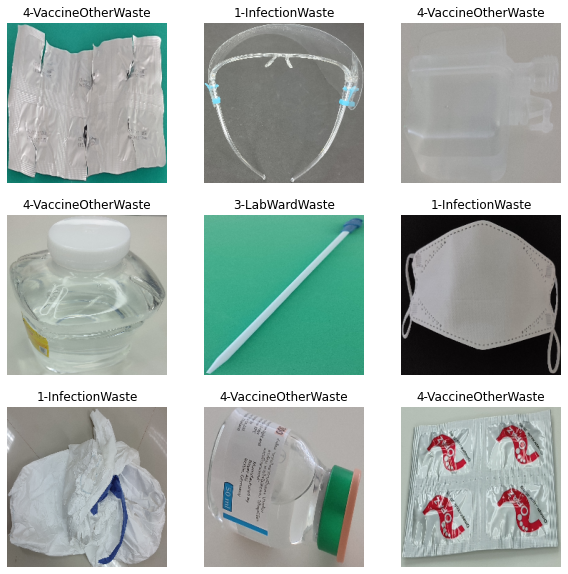

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.nasnet import preprocess_input,NASNetMobile
#                                                                                                                               VVVVVV  another model don't forgot to put softmax
transfered_model = keras.applications.NASNetMobile(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet") #,classifier_activation="softmax"

model_nooutput = transfered_model.layers[-2].output
custom_model = Model(inputs = transfered_model.input, outputs = model_nooutput)


## Freez Extractor+

In [18]:
custom_model.trainable = False
for layer in custom_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(ResNet152_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1056)              4269716   
_________________________________________________________________
dense (Dense)                (None, 1024)              1082368   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 5,356,184
Trainable params: 1,086,468
Non-trainable params: 4,269,716
_________________________________________________________________


In [22]:
#class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 46s 299ms/step - loss: 0.5204 - accuracy: 0.8165 - val_loss: 0.2303 - val_accuracy: 0.9133
Epoch 2/2000
49/49 [==============================] - 6s 124ms/step - loss: 0.1870 - accuracy: 0.9321 - val_loss: 0.1621 - val_accuracy: 0.9392
Epoch 3/2000
49/49 [==============================] - 6s 125ms/step - loss: 0.1249 - accuracy: 0.9586 - val_loss: 0.1399 - val_accuracy: 0.9521
Epoch 4/2000
49/49 [==============================] - 6s 125ms/step - loss: 0.0819 - accuracy: 0.9764 - val_loss: 0.1357 - val_accuracy: 0.9508
Epoch 5/2000
49/49 [==============================] - 6s 124ms/step - loss: 0.0539 - accuracy: 0.9868 - val_loss: 0.1777 - val_accuracy: 0.9379
Epoch 6/2000
49/49 [==============================] - 6s 124ms/step - loss: 0.0426 - accuracy: 0.9900 - val_loss: 0.1951 - val_accuracy: 0.9379
Epoch 7/2000
49/49 [==============================] - 6s 123ms/step - loss: 0.0360 - accuracy: 0.9913 - val_loss: 0.1410 - val_accuracy

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 6s 127ms/step - loss: 7.2668e-04 - accuracy: 1.0000 - val_loss: 0.1574 - val_accuracy: 0.9534
Epoch 202/2000
49/49 [==============================] - 6s 126ms/step - loss: 7.2706e-04 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9560
Epoch 203/2000
49/49 [==============================] - 6s 126ms/step - loss: 6.9683e-04 - accuracy: 1.0000 - val_loss: 0.1577 - val_accuracy: 0.9534
Epoch 204/2000
49/49 [==============================] - 6s 125ms/step - loss: 7.2136e-04 - accuracy: 1.0000 - val_loss: 0.1581 - val_accuracy: 0.9560
Epoch 205/2000
49/49 [==============================] - 6s 126ms/step - loss: 7.2571e-04 - accuracy: 1.0000 - val_loss: 0.1580 - val_accuracy: 0.9560
Epoch 206/2000
49/49 [==============================] - 6s 126ms/step - loss: 6.5648e-04 - accuracy: 1.0000 - val_loss: 0.1586 - val_accuracy: 0.9547
Epoch 207/2000
49/49 [==============================] - 6s 126ms/step - loss: 6.9617e-04 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 6s 128ms/step - loss: 5.2539e-05 - accuracy: 1.0000 - val_loss: 0.1985 - val_accuracy: 0.9560
Epoch 402/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.6509e-05 - accuracy: 1.0000 - val_loss: 0.1992 - val_accuracy: 0.9560
Epoch 403/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.8289e-05 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9560
Epoch 404/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.6184e-05 - accuracy: 1.0000 - val_loss: 0.1977 - val_accuracy: 0.9573
Epoch 405/2000
49/49 [==============================] - 6s 126ms/step - loss: 5.2811e-05 - accuracy: 1.0000 - val_loss: 0.1983 - val_accuracy: 0.9560
Epoch 406/2000
49/49 [==============================] - 6s 126ms/step - loss: 5.4662e-05 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9560
Epoch 407/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.7042e-05 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 6s 129ms/step - loss: 5.1522e-06 - accuracy: 1.0000 - val_loss: 0.2342 - val_accuracy: 0.9573
Epoch 602/2000
49/49 [==============================] - 6s 127ms/step - loss: 6.1257e-06 - accuracy: 1.0000 - val_loss: 0.2347 - val_accuracy: 0.9573
Epoch 603/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.5143e-06 - accuracy: 1.0000 - val_loss: 0.2350 - val_accuracy: 0.9573
Epoch 604/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.6490e-06 - accuracy: 1.0000 - val_loss: 0.2362 - val_accuracy: 0.9573
Epoch 605/2000
49/49 [==============================] - 6s 127ms/step - loss: 6.0338e-06 - accuracy: 1.0000 - val_loss: 0.2351 - val_accuracy: 0.9573
Epoch 606/2000
49/49 [==============================] - 6s 127ms/step - loss: 5.1820e-06 - accuracy: 1.0000 - val_loss: 0.2378 - val_accuracy: 0.9573
Epoch 607/2000
49/49 [==============================] - 6s 127ms/step - loss: 4.2698e-06 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 7s 129ms/step - loss: 9.4843e-07 - accuracy: 1.0000 - val_loss: 0.2671 - val_accuracy: 0.9586
Epoch 802/2000
49/49 [==============================] - 6s 128ms/step - loss: 9.6060e-07 - accuracy: 1.0000 - val_loss: 0.2672 - val_accuracy: 0.9586
Epoch 803/2000
49/49 [==============================] - 6s 128ms/step - loss: 9.3325e-07 - accuracy: 1.0000 - val_loss: 0.2675 - val_accuracy: 0.9586
Epoch 804/2000
49/49 [==============================] - 6s 128ms/step - loss: 1.2574e-06 - accuracy: 1.0000 - val_loss: 0.2688 - val_accuracy: 0.9586
Epoch 805/2000
49/49 [==============================] - 6s 130ms/step - loss: 1.0776e-06 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9586
Epoch 806/2000
49/49 [==============================] - 6s 127ms/step - loss: 9.4253e-07 - accuracy: 1.0000 - val_loss: 0.2698 - val_accuracy: 0.9586
Epoch 807/2000
49/49 [==============================] - 6s 127ms/step - loss: 1.0142e-06 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 7s 130ms/step - loss: 4.1867e-07 - accuracy: 1.0000 - val_loss: 0.2887 - val_accuracy: 0.9573
Epoch 1002/2000
49/49 [==============================] - 6s 128ms/step - loss: 3.9059e-07 - accuracy: 1.0000 - val_loss: 0.2896 - val_accuracy: 0.9599
Epoch 1003/2000
49/49 [==============================] - 6s 128ms/step - loss: 2.8206e-07 - accuracy: 1.0000 - val_loss: 0.2906 - val_accuracy: 0.9586
Epoch 1004/2000
49/49 [==============================] - 6s 128ms/step - loss: 3.1622e-07 - accuracy: 1.0000 - val_loss: 0.2913 - val_accuracy: 0.9586
Epoch 1005/2000
49/49 [==============================] - 6s 128ms/step - loss: 3.3883e-07 - accuracy: 1.0000 - val_loss: 0.2904 - val_accuracy: 0.9599
Epoch 1006/2000
49/49 [==============================] - 6s 128ms/step - loss: 3.4611e-07 - accuracy: 1.0000 - val_loss: 0.2907 - val_accuracy: 0.9599
Epoch 1007/2000
49/49 [==============================] - 6s 128ms/step - loss: 3.1857e-07 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 7s 131ms/step - loss: 2.0668e-07 - accuracy: 1.0000 - val_loss: 0.3057 - val_accuracy: 0.9599
Epoch 1202/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.7294e-07 - accuracy: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.9599
Epoch 1203/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.6635e-07 - accuracy: 1.0000 - val_loss: 0.3045 - val_accuracy: 0.9599
Epoch 1204/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.2969e-07 - accuracy: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.9599
Epoch 1205/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.4401e-07 - accuracy: 1.0000 - val_loss: 0.3053 - val_accuracy: 0.9599
Epoch 1206/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.5453e-07 - accuracy: 1.0000 - val_loss: 0.3055 - val_accuracy: 0.9599
Epoch 1207/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.6358e-07 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 7s 131ms/step - loss: 1.2129e-07 - accuracy: 1.0000 - val_loss: 0.3156 - val_accuracy: 0.9599
Epoch 1402/2000
49/49 [==============================] - 6s 130ms/step - loss: 1.3015e-07 - accuracy: 1.0000 - val_loss: 0.3170 - val_accuracy: 0.9599
Epoch 1403/2000
49/49 [==============================] - 6s 130ms/step - loss: 9.5444e-08 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9599
Epoch 1404/2000
49/49 [==============================] - 6s 129ms/step - loss: 9.6099e-08 - accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.9599
Epoch 1405/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.0111e-07 - accuracy: 1.0000 - val_loss: 0.3155 - val_accuracy: 0.9599
Epoch 1406/2000
49/49 [==============================] - 6s 129ms/step - loss: 8.9975e-08 - accuracy: 1.0000 - val_loss: 0.3150 - val_accuracy: 0.9599
Epoch 1407/2000
49/49 [==============================] - 6s 129ms/step - loss: 1.0357e-07 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 7s 131ms/step - loss: 6.1242e-08 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.9599
Epoch 1602/2000
49/49 [==============================] - 6s 130ms/step - loss: 6.2821e-08 - accuracy: 1.0000 - val_loss: 0.3226 - val_accuracy: 0.9599
Epoch 1603/2000
49/49 [==============================] - 6s 129ms/step - loss: 6.6249e-08 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.9599
Epoch 1604/2000
49/49 [==============================] - 6s 129ms/step - loss: 7.3259e-08 - accuracy: 1.0000 - val_loss: 0.3219 - val_accuracy: 0.9599
Epoch 1605/2000
49/49 [==============================] - 6s 129ms/step - loss: 7.2681e-08 - accuracy: 1.0000 - val_loss: 0.3228 - val_accuracy: 0.9599
Epoch 1606/2000
49/49 [==============================] - 6s 129ms/step - loss: 6.3437e-08 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9599
Epoch 1607/2000
49/49 [==============================] - 6s 129ms/step - loss: 7.6109e-08 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 7s 130ms/step - loss: 4.9032e-08 - accuracy: 1.0000 - val_loss: 0.3285 - val_accuracy: 0.9599
Epoch 1802/2000
49/49 [==============================] - 6s 129ms/step - loss: 4.7838e-08 - accuracy: 1.0000 - val_loss: 0.3283 - val_accuracy: 0.9599
Epoch 1803/2000
49/49 [==============================] - 6s 129ms/step - loss: 4.8685e-08 - accuracy: 1.0000 - val_loss: 0.3285 - val_accuracy: 0.9599
Epoch 1804/2000
49/49 [==============================] - 6s 129ms/step - loss: 5.1959e-08 - accuracy: 1.0000 - val_loss: 0.3284 - val_accuracy: 0.9599
Epoch 1805/2000
49/49 [==============================] - 6s 129ms/step - loss: 4.4102e-08 - accuracy: 1.0000 - val_loss: 0.3285 - val_accuracy: 0.9599
Epoch 1806/2000
49/49 [==============================] - 6s 129ms/step - loss: 4.2985e-08 - accuracy: 1.0000 - val_loss: 0.3283 - val_accuracy: 0.9599
Epoch 1807/2000
49/49 [==============================] - 6s 129ms/step - loss: 4.4833e-08 - ac

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

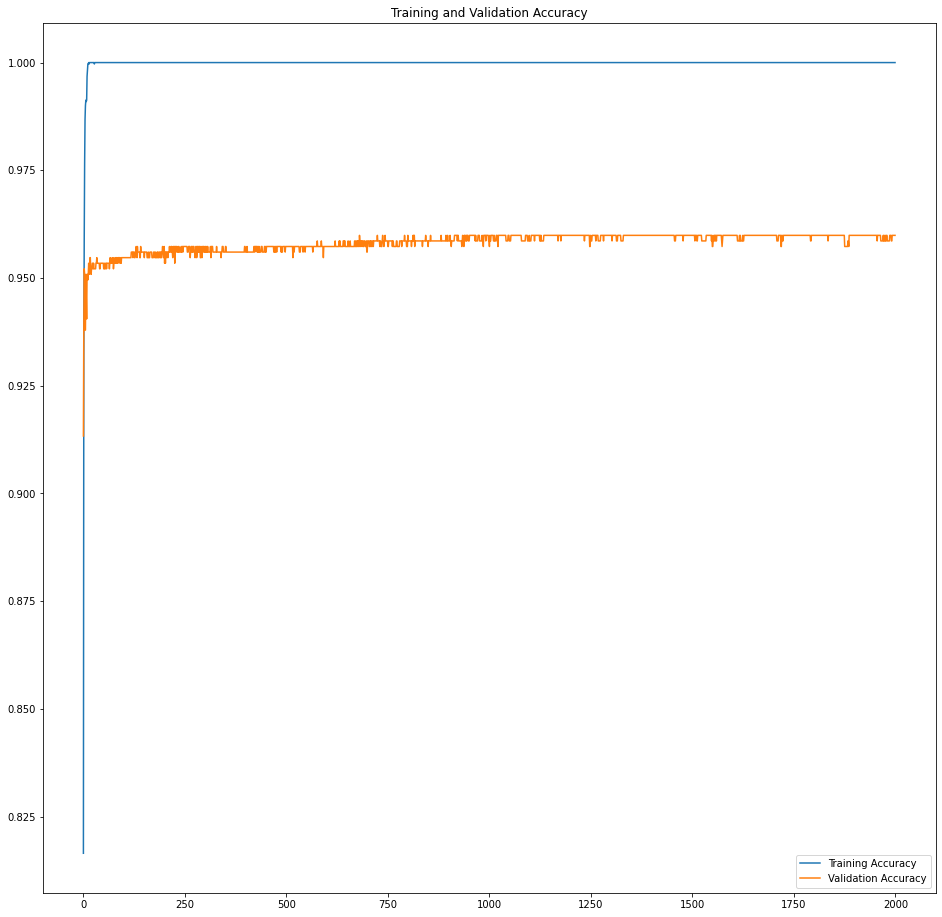

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


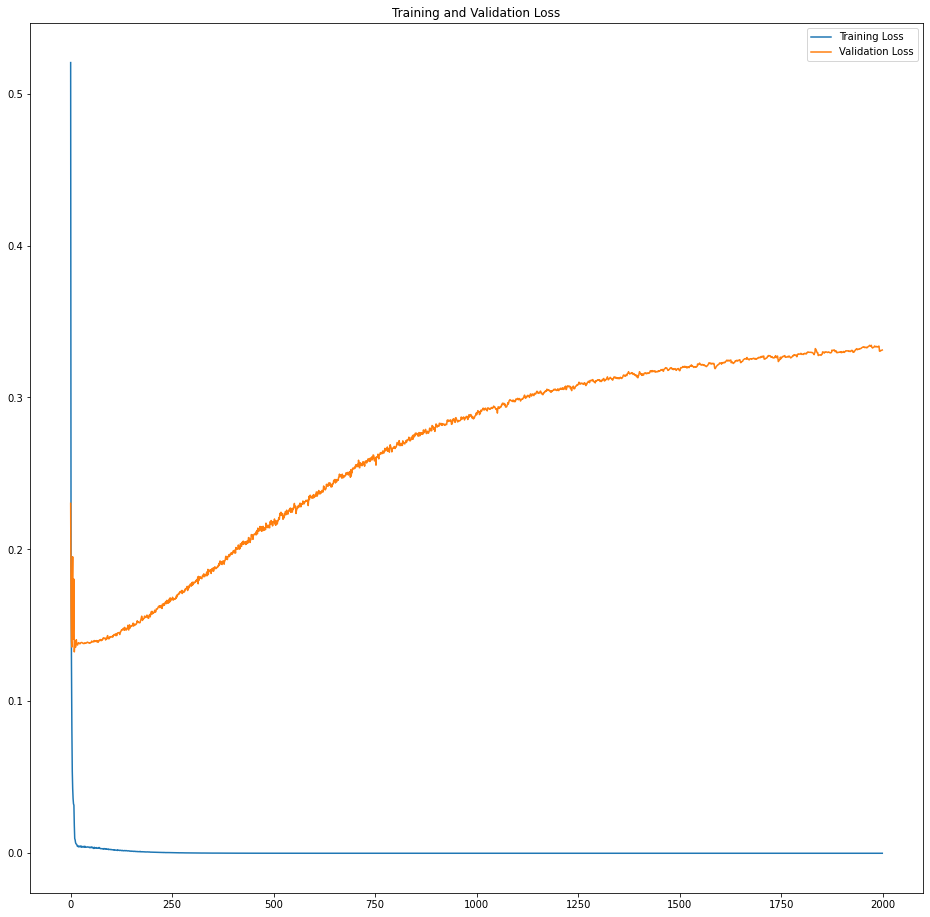

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 13s 316ms/step - loss: 1.2911 - accuracy: 0.8551
test_indoor_ds_results:test loss, test acc: [1.2910542488098145, 0.8550724387168884]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 418ms/step - loss: 2.1298 - accuracy: 0.8089
test_outdoor_ds_results:test loss, test acc: [2.12978196144104, 0.808917224407196]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 7s 170ms/step - loss: 2.3844 - accuracy: 0.7788
test_belt_ds_results:test loss, test acc: [2.3844025135040283, 0.7787851095199585]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1000.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1200.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1400.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb',
 'D:/ModelMedicalWasteCheckpoint/4G_NASNetMobile/OurOutputLayer_DeepDense-NoClassImbalanced-NoAu

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 4s 105ms/step - loss: 1.1161 - accuracy: 0.7797
Epoch200 
 test_indoor_acc=0.8483834862709045 
 test_outdoor_acc=0.8130573034286499 
 test_belt_acc=0.779691755771637
35/35 [==============================] - 4s 104ms/step - loss: 1.4201 - accuracy: 0.7811
Epoch400 
 test_indoor_acc=0.8522853851318359 
 test_outdoor_acc=0.8130573034286499 
 test_belt_acc=0.7810516953468323
35/35 [==============================] - 4s 106ms/step - loss: 1.7067 - accuracy: 0.7811
Epoch600 
 test_indoor_acc=0.8567447066307068 
 test_outdoor_acc=0.812738835811615 
 test_belt_acc=0.7810516953468323
35/35 [==============================] - 4s 104ms/step - loss: 1.9267 - accuracy: 0.7797
Epoch800 
 test_indoor_acc=0.8545150756835938 
 test_outdoor_acc=0.8095541596412659 
 test_belt_acc=0.779691755771637
35/35 [==============================] - 4s 104ms/step - loss: 2.0785 - accuracy: 0.7806
Epoch1000 
 test_indoor_acc=0.8539576530456543 
 test_outdoor_acc=0.80859869718551

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

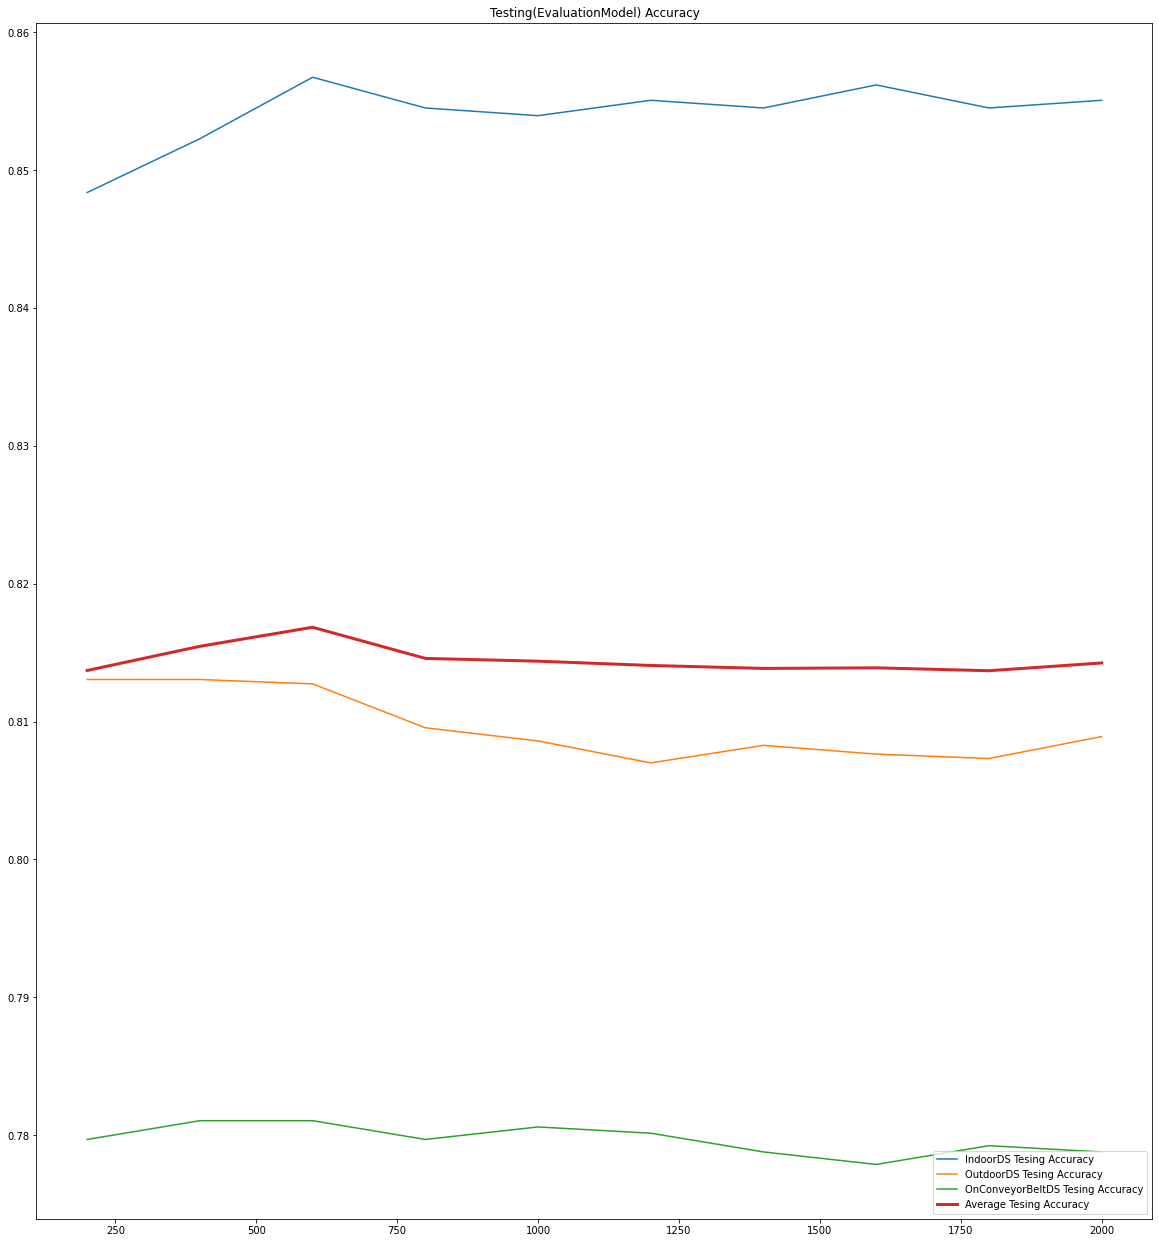

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.8168450792630514
max index -> 2
The [Epoch] of max acc -> 600


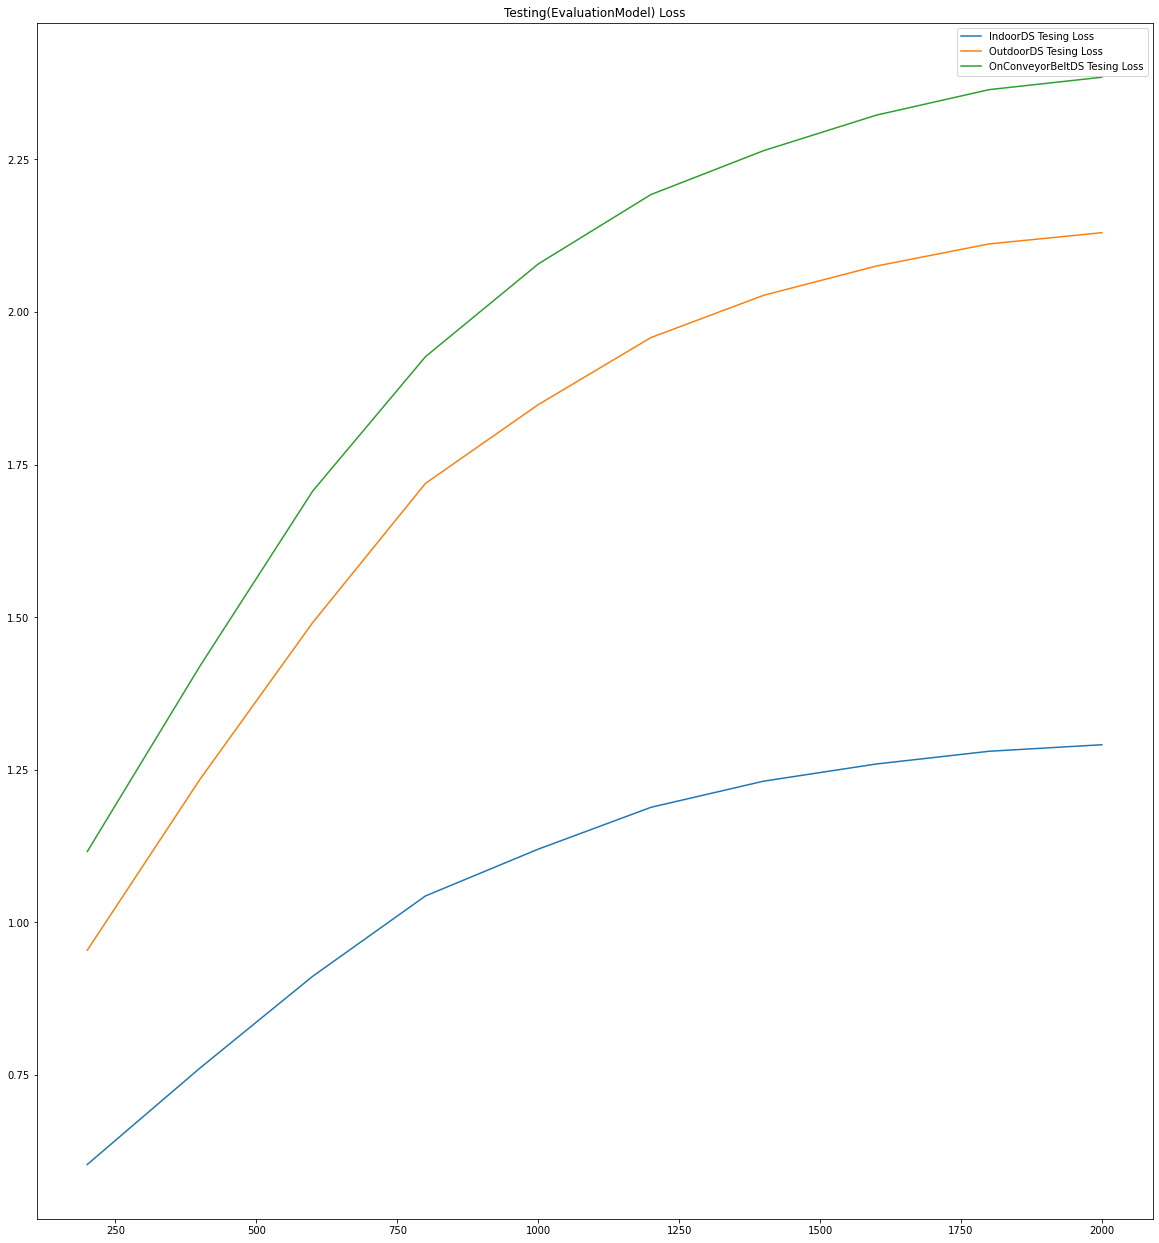

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8483834862709045,
 0.8522853851318359,
 0.8567447066307068,
 0.8545150756835938,
 0.8539576530456543,
 0.8550724387168884,
 0.8545150756835938,
 0.8561872839927673,
 0.8545150756835938,
 0.8550724387168884]

In [38]:
test_outdoor_acc

[0.8130573034286499,
 0.8130573034286499,
 0.812738835811615,
 0.8095541596412659,
 0.8085986971855164,
 0.8070063591003418,
 0.8082802295684814,
 0.8076432943344116,
 0.8073248267173767,
 0.808917224407196]

In [39]:
test_belt_acc

[0.779691755771637,
 0.7810516953468323,
 0.7810516953468323,
 0.779691755771637,
 0.7805983424186707,
 0.7801450490951538,
 0.7787851095199585,
 0.7778785228729248,
 0.7792384624481201,
 0.7787851095199585]

In [40]:
test_indoor_loss

[0.6036080718040466,
 0.7615585923194885,
 0.9118874073028564,
 1.0434105396270752,
 1.1200246810913086,
 1.1885483264923096,
 1.2314118146896362,
 1.259537935256958,
 1.280378818511963,
 1.2910542488098145]

In [41]:
test_outdoor_loss

[0.9544798135757446,
 1.2344715595245361,
 1.4912477731704712,
 1.7191975116729736,
 1.848055124282837,
 1.9580003023147583,
 2.027226448059082,
 2.075132369995117,
 2.111401319503784,
 2.12978196144104]

In [42]:
test_belt_loss

[1.1161437034606934,
 1.4200643301010132,
 1.7066971063613892,
 1.9267319440841675,
 2.0785179138183594,
 2.192232847213745,
 2.264173746109009,
 2.3223283290863037,
 2.3640763759613037,
 2.3844025135040283]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.nasnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb')

test_indoor_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_4Groups/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=224
img_width=224
batch_size=32

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1-InfectionWaste', '2-BloodSecretionWaste', '3-LabWardWaste', '4-VaccineOtherWaste']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
### VRAM not enough -> we split into N set
del x_test_indoor,x_test_outdoor,x_test_belt
N = 200
x_all_sets = np.array_split(x_all, N)
del x_all
y_all_sets_predicted = []
for x in x_all_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_all_predicted = np.concatenate(y_all_sets_predicted)


Found 1794 files belonging to 4 classes.
Found 3140 files belonging to 4 classes.
Found 2206 files belonging to 4 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5812
FP=1328
acc=0.8140056022408964
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1-InfectionWaste acc = 90.65420560747664%
2-BloodSecretionWaste acc = 63.74639769452449%
3-LabWardWaste acc = 77.27952167414051%
4-VaccineOtherWaste acc = 89.95796356842597%



all_avg_eachclass = 80.4095221361419%


In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[1746,   97,   34,   49],
       [ 485, 1106,   66,   78],
       [  81,  101, 1034,  122],
       [  17,   99,   99, 1926]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[90.65420561,  5.03634476,  1.76531672,  2.54413292],
       [27.95389049, 63.74639769,  3.80403458,  4.49567723],
       [ 6.05381166,  7.54857997, 77.27952167,  9.1180867 ],
       [ 0.79402149,  4.62400747,  4.62400747, 89.95796357]])

<AxesSubplot:>

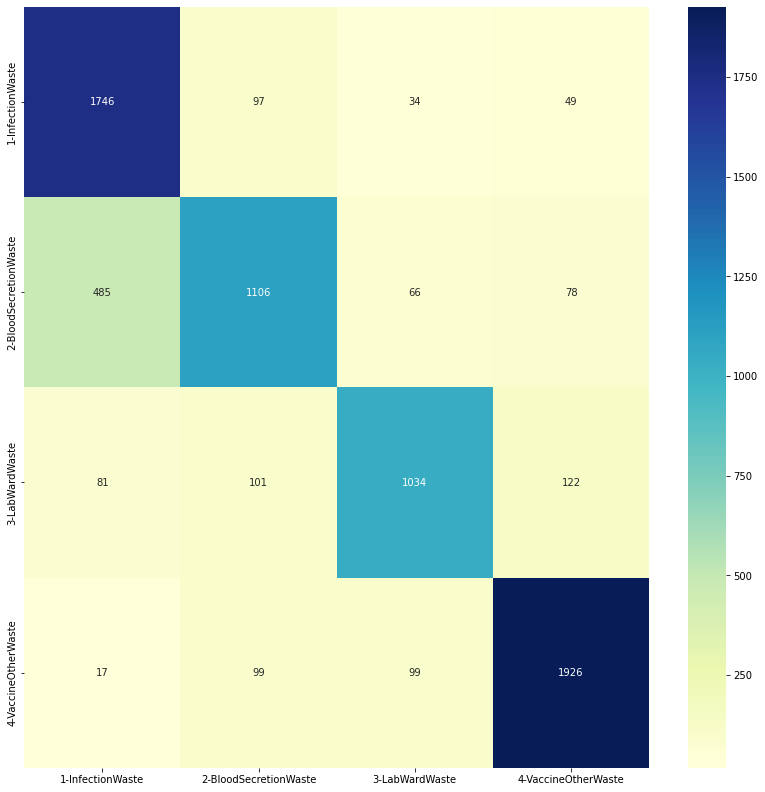

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

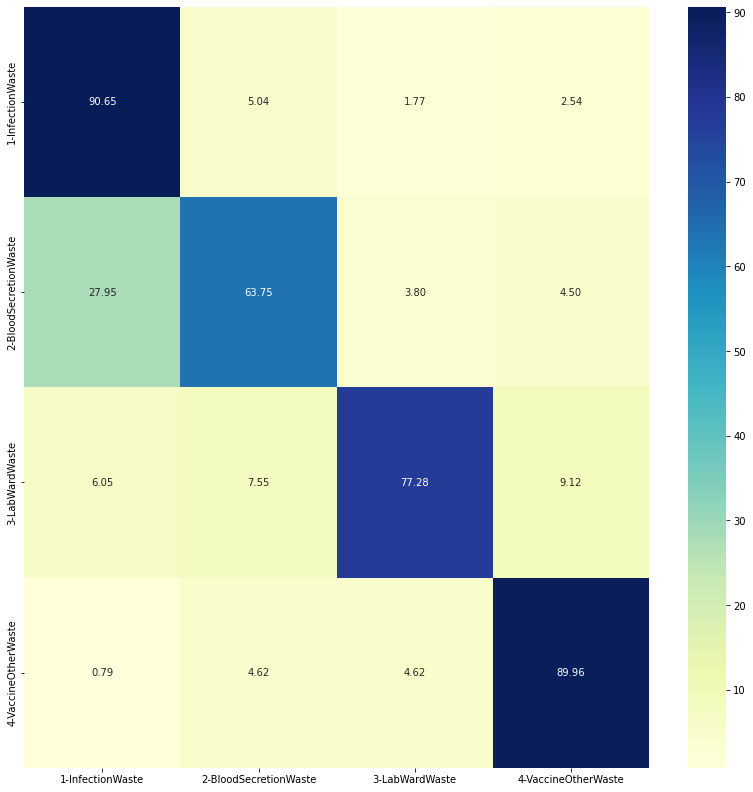

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")